<a href="https://colab.research.google.com/github/KTB2110/InsuranceCoveragePrediction/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/final_dfSI670.csv")

<ipython-input-50-a8b497d8c6e1>:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/final_dfSI670.csv")


In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'cert_num', 'name', 'address', 'city',
       'state', 'zip5', 'beds', 'payer', 'code', 'internal_revenue_code',
       'units', 'description', 'inpatient_outpatient', 'price',
       'code_disambiguator', 'BCBS', 'Medicare', 'Medicaid', 'UHC', 'Aetna',
       'Cigna', 'Cash Price', 'Gross Charge', 'HospitalInsurance'],
      dtype='object')

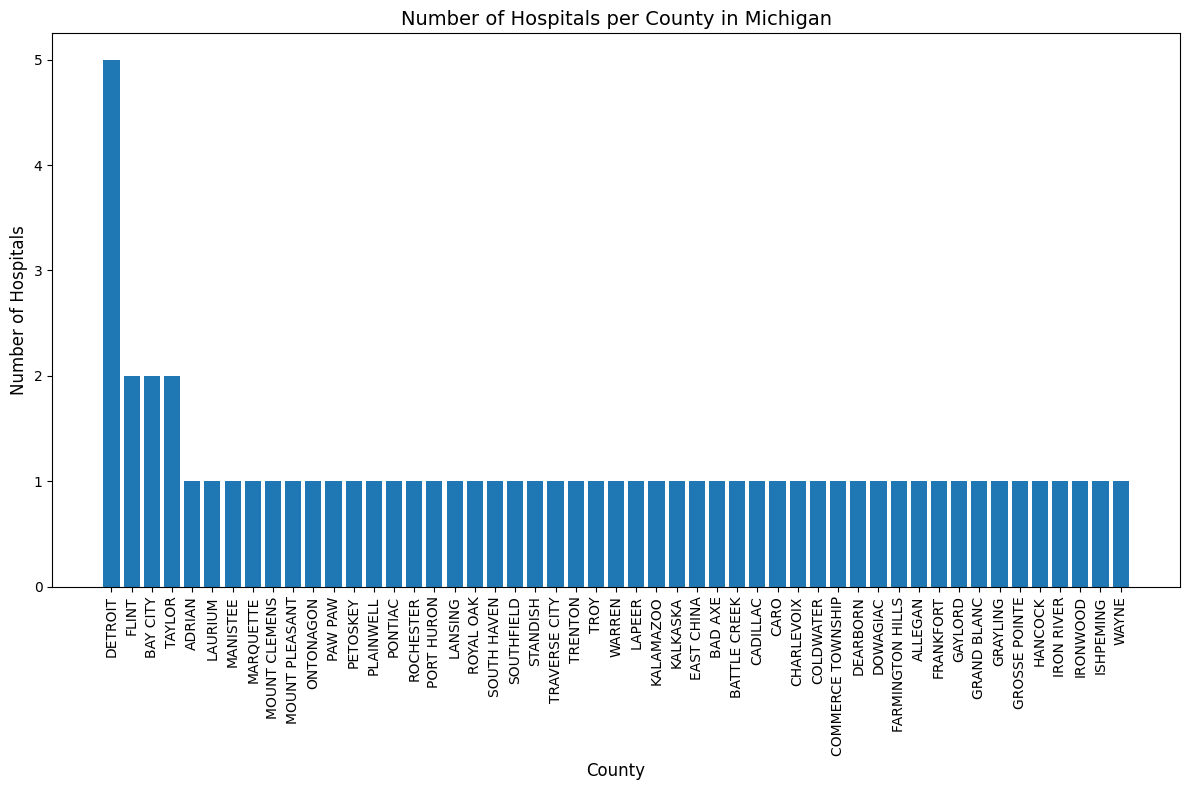

In [ ]:
df['county'] = df['city']  # Replace this with county-specific column if available

# Group by county and count the number of hospitals
county_hospitals = df.groupby('county')['name'].nunique().reset_index()
county_hospitals = county_hospitals.rename(columns={'name': 'hospital_count'})

# Sort by number of hospitals for better visualization
county_hospitals = county_hospitals.sort_values('hospital_count', ascending=False)

# Plot the data
plt.figure(figsize=(12, 8))
plt.bar(county_hospitals['county'], county_hospitals['hospital_count'], width=0.8)
plt.xlabel('County', fontsize=12)
plt.ylabel('Number of Hospitals', fontsize=12)
plt.title('Number of Hospitals per County in Michigan', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

### Baseline Models: Mean Price grouped by the following criteria

Hospital, Condition = 12035.0844

Condition = 13214.2

Hospital, Condition, Insurance = 2134.6

Zipcode, Condition = 12070.14

In [ ]:
groupby_condition = ["zip5", "description"]
means = df.groupby(groupby_condition)['price'].mean().reset_index()

In [ ]:
merged = df.merge(means, on=groupby_condition, how='left')

In [ ]:
merged = merged.rename(columns={'price_x':'price', 'price_y':'mean_price'})

merged['squared_diff'] = (merged['price'] - merged['mean_price'])**2

rmse = np.sqrt(merged['squared_diff'].mean())
print(f"RMSE: {rmse}")

RMSE: 12070.135664762738


## Random Forest Model

Split the dataset

<br>

Scale the dataset
<br>
Check for data leakage

<br>

Hyper parameter tuning

Cross-validation

In [2]:
import pandas as pd

In [10]:
train_df = pd.read_csv("/content/drive/MyDrive/si670project/train_df_name_enc.csv")
test_df = pd.read_csv("/content/drive/MyDrive/si670project/test_df_name_enc.csv")

In [4]:
"/content/drive/MyDrive/si670project/d_embeddings.npz"


'/content/drive/MyDrive/si670project/d_embeddings.npz'

In [5]:
import numpy as np

data = np.load("/content/drive/MyDrive/si670project/d_embeddings.npz")

print(data.files)
embeddings = data['arr_0']
embeddings.shape


['arr_0']


(271874, 768)

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 15 00:02:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


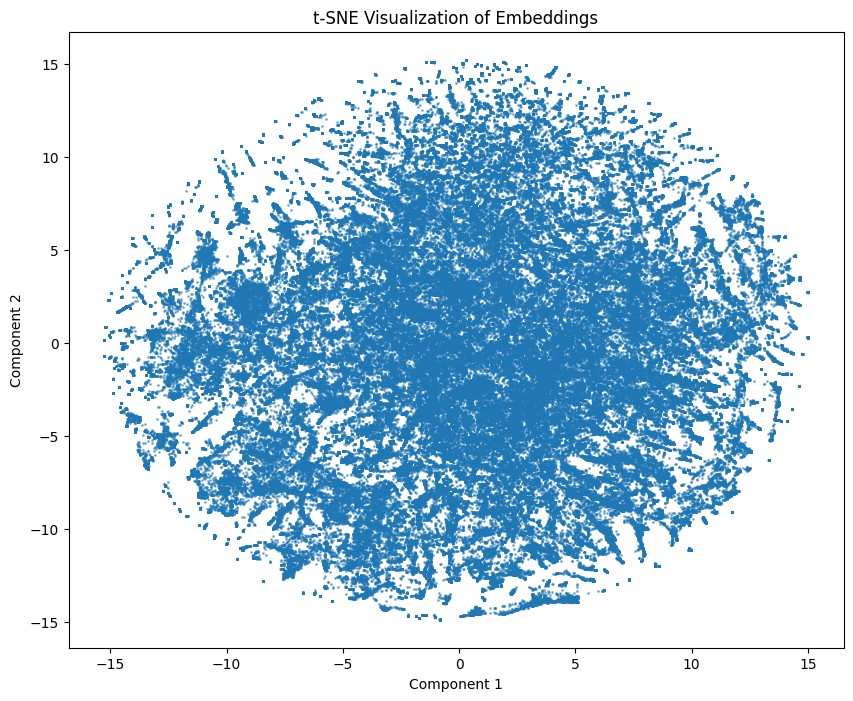

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=300)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1, alpha=0.5)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [ ]:
# train_df['name'].nunique()

46

In [ ]:
# train_df.drop(columns=['Unnamed: 0', 'internal_revenue_code'], inplace=True)
# test_df.drop(columns=['Unnamed: 0', 'internal_revenue_code'], inplace=True)

In [11]:
def find_columns_with_unwanted_chars(df):
    unwanted_columns = [col for col in df.columns if any(c in col for c in '[]<')]
    return unwanted_columns

# Check columns in train_df
unwanted_train_cols = find_columns_with_unwanted_chars(train_df)
print("Columns in train_df with unwanted characters:", unwanted_train_cols)

Columns in train_df with unwanted characters: ['payer_AETNA ALLIED BENEFIT SYSTEMS [18109]', 'payer_AETNA HMO POS [17005]', 'payer_BCBS TRADITIONAL [1022]', 'payer_BCBSM SMART HEALTH ABS PPO [1583]', 'payer_BCN HMO [1016]', 'payer_BEAUMONT HEALTH EMPLOYEE PLAN [18010]', 'payer_HIX BCBS [14005]', 'payer_HIX BCN [14010]', 'payer_HIX PRIORITY BEAUMONT HEALTH [14040]', 'payer_MEDICARE PLUS BLUE PPO [1566]', 'payer_MMCD ABH AETNA [19005]', 'payer_MMCD UHC HMP [19051]', 'payer_MMCR ABH AETNA MI HEALTH LINK OON [1963]', 'payer_MMCR AETNA [12005]', 'payer_MMCR BCN ADVANTAGE HMO [12070]', 'payer_MMCR MEDICARE PLUS BLUE PPO [12025]', 'payer_MMCR MOLINA MEDICARE COMPLETE CARE [12042]', 'payer_MMCR UHC [12050]', 'payer_UHC CORE COMPASS [17030]', 'payer_UHC OTHER [18069]', 'payer_UHC PPO [18067]']


In [12]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[\[\]<]', '', regex=True)
    return df

# Clean column names for train_df and test_df
train_df = clean_column_names(train_df)
test_df = clean_column_names(test_df)

In [13]:
unwanted_train_cols = find_columns_with_unwanted_chars(train_df)
print("Columns in train_df with unwanted characters:", unwanted_train_cols)

Columns in train_df with unwanted characters: []


In [ ]:
# prompt: find columns that have outpatient in the name

import pandas as pd

# Assuming your DataFrame is named 'df'
# Replace 'df' with your actual DataFrame name if it's different.

outpatient_columns = [col for col in train_df.columns if 'outpatient' in col.lower()]

outpatient_columns

['inoutpatient_INPATIENT',
 'inoutpatient_OUTPATIENT',
 'inoutpatient_UNSPECIFIED']

In [ ]:
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Prepare the data
# X_train = train_df.drop(columns=['price'])  # Replace 'price' with your target column name
# y_train = train_df['price']
# X_test = test_df.drop(columns=['price'])
# y_test = test_df['price']

# # Initialize the XGBoost Regressor
# xgb_regressor = XGBRegressor(
#     random_state=42,
#     n_estimators=100,  # Number of boosting rounds
#     learning_rate=0.1,  # Step size shrinkage
#     max_depth=6,  # Maximum depth of a tree
#     objective='reg:squarederror'  # Regression objective
# )

# # Train the model
# xgb_regressor.fit(X_train, y_train)

# # Make predictions
# y_pred = xgb_regressor.predict(X_test)

# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print(f"RMSE: {rmse}")

# # Optional: Feature Importance
# importances = xgb_regressor.feature_importances_
# feature_names = X_train.columns
# for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
#     print(f"{name}: {importance:.4f}")


RMSE: 20755.464224695363
inoutpatient_OUTPATIENT: 0.1346
payer_GROSS CHARGE: 0.1093
payer_COFINITY - Automobile, Medical: 0.0542
name_ASCENSION BORGESS PIPP HOSPITAL: 0.0337
name_HURLEY MEDICAL CENTER: 0.0281
BCBS: 0.0244
payer_BCN HMO 1016: 0.0200
payer_BCBSM SMART HEALTH ABS PPO 1583: 0.0188
payer_McLaren Hospice: 0.0155
zip5: 0.0152
payer_MMCR BCN ADVANTAGE HMO 12070: 0.0148
Gross Charge: 0.0142
payer_Aetna BMT: 0.0137
Medicaid: 0.0136
name_MCLAREN FLINT: 0.0133
payer_BLUE CROSS BLUE SHIELD J16 BCN GENESYS PHO 00180 486: 0.0126
payer_BLUE CROSS BLUE SHIELD U16 BLUECARE UNJUSTIFIED 00180 486: 0.0125
name_ASCENSION MACOMB OAKLAND HOSP-WARREN CAMPUS: 0.0125
beds: 0.0117
name_MUNSON MEDICAL CENTER: 0.0117
payer_MEDICARE PLUS BLUE PPO 1566: 0.0104
Medicare: 0.0103
inoutpatient_INPATIENT: 0.0098
payer_MMCD ABH AETNA 19005: 0.0091
payer_MMCD UHC HMP 19051: 0.0090
payer_AETNA ALLIED BENEFIT SYSTEMS 18109: 0.0087
payer_BLUE CROSS BLUE SHIELD Z11 BLUE CROSS COMPLETE HMP 1864: 0.0087
payer_HIX

In [ ]:
train_df.head()

,zip5,beds,price,BCBS,Medicare,Medicaid,UHC,Aetna,Cigna,Cash Price,...,name_PAUL OLIVER MEMORIAL HOSPITAL,name_PROMEDICA CHARLES AND VIRGINIA HICKMAN HOSPITAL,name_PROMEDICA COLDWATER REGIONAL HOSPITAL,name_SINAI-GRACE HOSPITAL,name_UP HEALTH SYSTEM - MARQUETTE,name_UP HEALTH SYSTEM PORTAGE,name_VIBRA HOSPITAL OF SOUTHEASTERN MI-TAYLOR CAMPUS,inoutpatient_INPATIENT,inoutpatient_OUTPATIENT,inoutpatient_UNSPECIFIED
0,49007,380,195.70,0,0,1,0,1,0,0,...,False,False,False,False,False,False,False,False,True,False
1,49007,380,450.48,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
2,49007,380,375.16,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,49007,380,1769.16,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,True,False
4,49007,380,1769.16,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Prepare the data
# X_train = train_df.drop(columns=['price'])  # Replace 'price' with your target column name
# y_train = train_df['price']
# X_test = test_df.drop(columns=['price'])
# y_test = test_df['price']

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 200, 500],  # Number of trees
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
#     'max_features': ['sqrt', 'log2']  # Number of features considered for split
# }

# # Initialize the Random Forest Regressor
# rf_regressor = RandomForestRegressor(random_state=42)

# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=rf_regressor,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',  # Use RMSE as the evaluation metric
#     cv=3,  # 3-fold cross-validation
#     verbose=3,
#     n_jobs=-1  # Use all available cores
# )

# # Perform grid search
# grid_search.fit(X_train, y_train)

# # Best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Make predictions with the best model
# y_pred = best_model.predict(X_test)

# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print(f"Best Parameters: {best_params}")
# print(f"RMSE: {rmse}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [16]:
# prompt: make pandas show me all the columns

import pandas as pd

pd.set_option('display.max_columns', None)

In [17]:
train_df.head()

,zip5,beds,price,BCBS,Medicare,Medicaid,UHC,Aetna,Cigna,Cash Price,Gross Charge,HospitalInsurance,birch_cluster,payer_AETNA,payer_AETNA - Commercial,payer_AETNA - PPO,payer_AETNA / COVENTRY,payer_AETNA 120101 120101 AETNA MEDICARE ADVANTAGE 601,payer_AETNA 120101 120101 AETNA MEDICARE ADVANTAGE 615,payer_AETNA 120116 120116 AETNA BETTER HLTH MI 601,payer_AETNA 120116 120116 AETNA BETTER HLTH MI 615,payer_AETNA 1747,payer_AETNA 210109 210109 AETNA BETTER HLTH MI CAID 630,payer_AETNA 210109 210109 AETNA BETTER HLTH MI CAID 676,payer_AETNA 210120 210120 AETNA BET HLT MI CAID HMP 630,payer_AETNA 210120 210120 AETNA BET HLT MI CAID HMP 676,payer_AETNA 4008 AETNA ADVANTAGE 553,payer_AETNA 4008 AETNA ADVANTAGE 658,payer_AETNA 4070 AETNA BTR HLTH MI HLTH LNK 554,payer_AETNA 4070 AETNA BTR HLTH MI HLTH LNK 660,payer_AETNA 5017 AETNA BTR HLTH MEMIHEAL 715,payer_AETNA 5085 AETNA BTR HLTH MEMIMED1 715,payer_AETNA 8035 AETNA 712,payer_AETNA ABH AETNA BTR HLTH MI HLTH LN 1301,payer_AETNA ABH AETNA BTR HLTH MI HLTH LN 1600,payer_AETNA ABH AETNA BTR HLTH MI HLTH LN 1604,payer_AETNA ALLIED BENEFIT SYSTEMS 18109,payer_AETNA AMERICAN CONTINENTAL 8843,payer_AETNA AMO AETNA MEDICARE 1301,payer_AETNA AMO AETNA MEDICARE 1309,payer_AETNA AMO AETNA MEDICARE 1600,payer_AETNA AMO AETNA MEDICARE 1617,payer_AETNA BETTER HEALTH MANAGED MEDICAID,payer_AETNA BETTER HEALTH OF MICHIGAN - Medicaid Advantage,payer_AETNA BOLE AETNA 20210701 2678,payer_AETNA C21 AETNA PPO 1617,payer_AETNA COMMERCIAL,payer_AETNA D11 F AETNA MEDICARE 726,payer_AETNA D11 F AETNA MEDICARE 914,payer_AETNA E70 AETNA BTR HLTH MI HLTH LN 726,payer_AETNA E70 AETNA BTR HLTH MI HLTH LN 914,payer_AETNA FOREIGN SERVICE BENEFIT PLAN 10160,payer_AETNA GLOBAL BENEFITS,payer_AETNA H01 AETNA 485,payer_AETNA H07 AETNA ADVANTAGE 484,payer_AETNA H07 AETNA ADVANTAGE 539,payer_AETNA HMO POS 17005,payer_AETNA HTH WORLDWIDE,payer_AETNA I97 AETNA BTR HLTH MEMIMED1 1438,payer_AETNA I97 AETNA BTR HLTH MEMIMED1 1869,payer_AETNA I97 AETNA BTR HLTH MEMIMED1 1877,payer_AETNA INSURANCE,payer_AETNA INTERNATIONAL,payer_AETNA LIFE INS,payer_AETNA LIFE INS CO,payer_AETNA MEDICAID BOMC MEDICAID REPLACEMENT AETNA BETTER HEALTH INPATIENT 20201001 2430,payer_AETNA MEDICAID72S AETNA BETTER HLTH MEDICAD2430,payer_AETNA MEDICAIDCHM AETNA BETTER HLTH HMP2430,payer_AETNA MICHIGAN PREFERRED BOLE AETNA MICHIGAN PREFERRED 20200701 2410,payer_AETNA MICHIGAN PREFERRED210 AETNA MICHIGAN PREFERRED2410,payer_AETNA MTU STUDENT INS,payer_AETNA N45 AETNA BTR HLTH MEMIMED1 1861,payer_AETNA PPO,payer_AETNA PRISON HEALTH SERVICES,payer_AETNA S15 F JVHL 1025,payer_AETNA STUDENT INS PENDING ID,payer_AETNA T86 AETNA BTR HLTH MEMIMED1 1039,payer_AETNA T92 F AETNA 1025,payer_AETNA T93 F AETNA 1025,payer_AETNA Z07 AETNA BTR HLTH MEMIHEAL 1039,payer_AETNA Z07 AETNA BTR HLTH MEMIHEAL 1861,payer_AETNA Z07 AETNA BTR HLTH MEMIHEAL 1869,payer_AETNA/MEDICARE HMO,payer_AETNA917 AETNA PO BOX 9811062678,payer_AETNA97A NGS AETNA SIGNATURE ADM2678,payer_AETNA97H AETNA SIGNATURE MISC PPO2678,payer_ALLIANCE MEDICARE PPO,payer_APWU CIGNA 9982,payer_Aetna,payer_Aetna Aetna Commercial,payer_Aetna Aetna Funding Advantage (AFA),payer_Aetna BMT,payer_Aetna Commercial,payer_Aetna Health Insurance Company Commercial,payer_Aetna Indemnity Insurance,payer_Aetna Medicare,payer_Aetna Medicare Advantage,payer_Aetna PPO,payer_Aetna Preferred Provider Organization (PPO),payer_Aetna US Healthcare Commercial,payer_AetnaAetna Commercial,payer_AetnaAetna Funding Advantage (AFA),payer_Anthem Blue Cross Blue Shield Blue Access Traditional - PPO/PAR,payer_Anthem Blue Cross Blue Shield Blue Access/Traditional - PPO/PAR,payer_Anthem Blue Cross Blue Shield Blue Preferred - HMO/POS,payer_Anthem Blue Cross Blue Shield Blue Priority - POS WI Statewide,"payer_Aspirus Health Plan, Inc. Aspirus Health Plan Commercial HMO/POS","payer_Aspirus Health Plan, Inc. Aspirus Health Plan Commercial HMO/POS","payer_Aspirus Health Plan, Inc.Aspirus Health Plan Commercial HMO/POS",payer_BC BCBSM TRUST,

In [ ]:
['zip5', 'beds', 'price', 'birch_cluster']

In [14]:
# prompt: import standard scaler

from sklearn.preprocessing import StandardScaler

In [20]:
# prompt: filter out all the rows that have a price greater than 35000 in train df and test_df and then show me the number of rows for both

import pandas as pd

# Assuming train_df and test_df are already defined as in your provided code

train_df_filtered = train_df[train_df['price'] <= 35000]
test_df_filtered = test_df[test_df['price'] <= 35000]

print("Number of rows in filtered train_df:", len(train_df_filtered))
print("Number of rows in filtered test_df:", len(test_df_filtered))

Number of rows in filtered train_df: 438718
Number of rows in filtered test_df: 149748


In [18]:
# Specify the columns to scale
columns_to_scale = ['zip5', 'beds', 'birch_cluster']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale only the specified columns
scaled_values = scaler.fit_transform(train_df[columns_to_scale])

# Create a DataFrame for the scaled values with the same column names
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=train_df.index)

# Replace the original columns in train_df with the scaled values
train_df[columns_to_scale] = scaled_df

# (Optional) If needed, do the same for test_df
scaled_values_test = scaler.transform(test_df[columns_to_scale])
scaled_df_test = pd.DataFrame(scaled_values_test, columns=columns_to_scale, index=test_df.index)
test_df[columns_to_scale] = scaled_df_test

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data
X_train = train_df.drop(columns=['price'])  # Replace 'price' with your target column name
y_train = train_df['price']
X_test = test_df.drop(columns=['price'])
y_test = test_df['price']


# # Initialize the StandardScaler
# scaler = StandardScaler()
# # Fit the scaler on the training data
# X_train_scaled = scaler.fit_transform(X_train)
# # Transform the test data using the same scaler
# X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(
    random_state=42,
    n_estimators=200,  # Number of trees
    max_depth=None  # No maximum depth (can be adjusted)
)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE: {rmse}")

RMSE: 14027.57522097774


In [21]:
# Specify the columns to scale
columns_to_scale = ['zip5', 'beds', 'birch_cluster']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale only the specified columns
scaled_values = scaler.fit_transform(train_df_filtered[columns_to_scale])

# Create a DataFrame for the scaled values with the same column names
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=train_df_filtered.index)

# Replace the original columns in train_df_filtered with the scaled values
train_df_filtered[columns_to_scale] = scaled_df

# (Optional) If needed, do the same for test_df_filtered
scaled_values_test = scaler.transform(test_df_filtered[columns_to_scale])
scaled_df_test = pd.DataFrame(scaled_values_test, columns=columns_to_scale, index=test_df_filtered.index)
test_df_filtered[columns_to_scale] = scaled_df_test

<ipython-input-21-715881061ad6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_filtered[columns_to_scale] = scaled_df
<ipython-input-21-715881061ad6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_filtered[columns_to_scale] = scaled_df_test


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data
X_train = train_df_filtered.drop(columns=['price'])  # Replace 'price' with your target column name
y_train = train_df_filtered['price']
X_test = test_df_filtered.drop(columns=['price'])
y_test = test_df_filtered['price']
2

# # Initialize the StandardScaler
# scaler = StandardScaler()
# # Fit the scaler on the training data
# X_train_scaled = scaler.fit_transform(X_train)
# # Transform the test data using the same scaler
# X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(
    random_state=42,
    n_estimators=200,  # Number of trees
    max_depth=None  # No maximum depth (can be adjusted)
)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE: {rmse}")

RMSE: 4852.608131359349


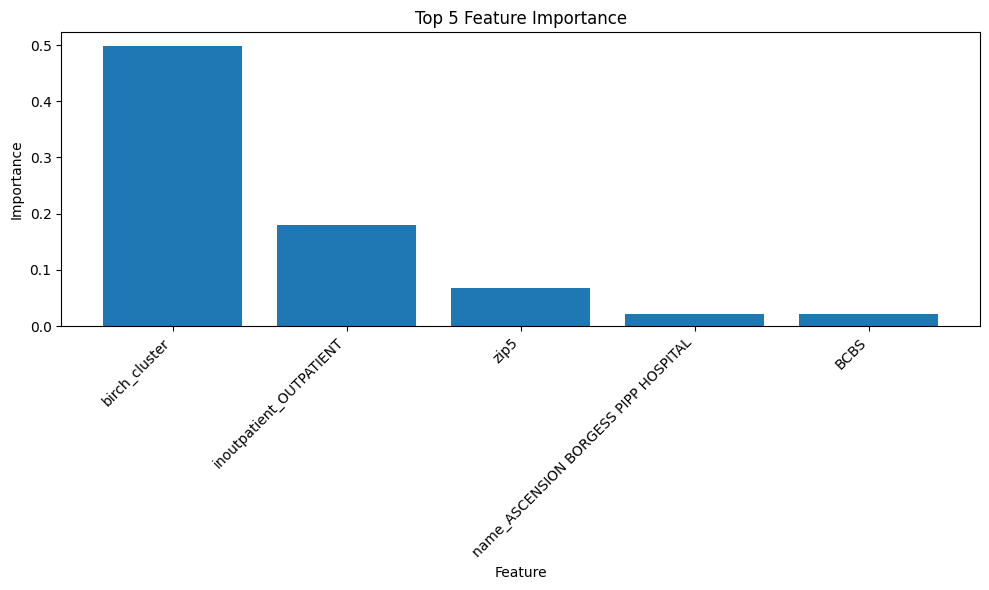

In [27]:
# prompt: can you create a bar chart to show the feature importance of the top 5 features of the rf_regressor

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Assuming rf_regressor is already trained as in your provided code
# and X_train is defined

# Get feature importances
importances = rf_regressor.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a DataFrame for easier sorting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Get the top 5 features
top_5_features = feature_importance_df.head(5)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_5_features['Feature'], top_5_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 5 Feature Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [28]:
top_5_features

,Feature,Importance
11,birch_cluster,0.497732
884,inoutpatient_OUTPATIENT,0.179583
0,zip5,0.067138
827,name_ASCENSION BORGESS PIPP HOSPITAL,0.022009
2,BCBS,0.021105


In [29]:
feature_importance_df

,Feature,Importance
11,birch_cluster,0.497732
884,inoutpatient_OUTPATIENT,0.179583
0,zip5,0.067138
827,name_ASCENSION BORGESS PIPP HOSPITAL,0.022009
2,BCBS,0.021105
...,...,...
365,payer_MEDICARE C49 COMM AARP HEALTHCARE OPTI 1617,0.000000
313,payer_CignaCommercial Plans,0.000000
107,"payer_Aspirus Health Plan, Inc.Aspirus Health ...",0.000000
111,payer_BC OF MICH TRAD BOLE BLUE CROSS BLUE SHI...,0.000000


In [31]:
y_train_pred = rf_regressor.predict(X_train)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

KeyboardInterrupt: 

In [32]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {rmse}")

Train RMSE: 3105.866117788408
Test RMSE: 4852.608131359349
